# Ví dụ 1

Chúng ta vẫn bắt đầu với một ví dụ trên dữ liệu nhân tạo. Trước hết ta tạo một bộ dữ liệu có 200 mẫu
(N=200) phân đều vào 02 lớp – mỗi lớp 100 phần tử. Mỗi mẫu có 2 chiều (d=2). Dữ liệu sẽ được chúng ta tạo
bởi make_circles trong thư viện sklearn.dataset sao cho đường biên giữa các lớp là không tuyến tính.
Tiếp theo sử dụng thư viện sklearn để minh họa phương pháp Kernel Vector Machine với các hàm nhân khác
nhau và tiến hành thực hiện phân lớp trên bộ dữ liệu nói trên.

## Cách 1: Tự xây dựng các module từ thư viện Numpy:

In [74]:
import numpy as np
from numpy import linalg
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import cvxopt
import cvxopt.solvers

In [75]:
# viết các hàm kernel
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x, y, gamma = 1, r = 1, d=3):
    return (r + gamma*np.dot(x, y)) ** d

def gaussian_kernel(x, y, sigma=5.0):
    # gamma = 1.0/(2 * (sigma ** 2))
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

In [76]:
class SVM(object):

    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None: self.C = float(self.C)

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Gram matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])

        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)

        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        a = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print("%d support vectors out of %d points" % (len(self.a), n_samples))

        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
        self.b /= len(self.a)

        # Weight vector
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None

    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b

    def predict(self, X):
        return np.sign(self.project(X))

In [77]:
import pylab as pl


def gen_lin_separable_data():
    # generate training data in the 2-d case
    mean1 = np.array([0, 2])
    mean2 = np.array([2, 0])
    cov = np.array([[0.8, 0.6], [0.6, 0.8]])
    X1 = np.random.multivariate_normal(mean1, cov, 100)
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 100)
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

def gen_non_lin_separable_data():
    mean1 = [-1, 2]
    mean2 = [1, -1]
    mean3 = [4, -4]
    mean4 = [-4, 4]
    cov = [[1.0,0.8], [0.8, 1.0]]
    X1 = np.random.multivariate_normal(mean1, cov, 50)
    X1 = np.vstack((X1, np.random.multivariate_normal(mean3, cov, 50)))
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 50)
    X2 = np.vstack((X2, np.random.multivariate_normal(mean4, cov, 50)))
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2


def gen_lin_separable_overlap_data():
    # generate training data in the 2-d case
    mean1 = np.array([0, 2])
    mean2 = np.array([2, 0])
    cov = np.array([[1.5, 1.0], [1.0, 1.5]])
    X1 = np.random.multivariate_normal(mean1, cov, 100)
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 100)
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2


def split_train(X1, y1, X2, y2):
    X1_train = X1[:90]
    y1_train = y1[:90]
    X2_train = X2[:90]
    y2_train = y2[:90]
    X_train = np.vstack((X1_train, X2_train))
    y_train = np.hstack((y1_train, y2_train))
    return X_train, y_train

def split_test(X1, y1, X2, y2):
    X1_test = X1[90:]
    y1_test = y1[90:]
    X2_test = X2[90:]
    y2_test = y2[90:]
    X_test = np.vstack((X1_test, X2_test))
    y_test = np.hstack((y1_test, y2_test))
    return X_test, y_test

def plot_margin(X1_train, X2_train, clf):
    def f(x, w, b, c=0):
        # given x, return y such that [x,y] in on the line
        # w.x + b = c
        return (-w[0] * x - b + c) / w[1]

    pl.plot(X1_train[:,0], X1_train[:,1], "ro")
    pl.plot(X2_train[:,0], X2_train[:,1], "bo")
    pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

    # w.x + b = 0
    a0 = -4; a1 = f(a0, clf.w, clf.b)
    b0 = 4; b1 = f(b0, clf.w, clf.b)
    pl.plot([a0,b0], [a1,b1], "k")

    # w.x + b = 1
    a0 = -4; a1 = f(a0, clf.w, clf.b, 1)
    b0 = 4; b1 = f(b0, clf.w, clf.b, 1)
    pl.plot([a0,b0], [a1,b1], "k--")

    # w.x + b = -1
    a0 = -4; a1 = f(a0, clf.w, clf.b, -1)
    b0 = 4; b1 = f(b0, clf.w, clf.b, -1)
    pl.plot([a0,b0], [a1,b1], "k--")

    pl.axis("tight")
    pl.show()
    
def plot_contour(X1_train, X2_train, clf):
    pl.plot(X1_train[:,0], X1_train[:,1], "ro")
    pl.plot(X2_train[:,0], X2_train[:,1], "bo")
    pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

    X1, X2 = np.meshgrid(np.linspace(-6,6,50), np.linspace(-6,6,50))
    X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
    Z = clf.project(X).reshape(X1.shape)
    pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
    pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
    pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')

    pl.axis("tight")
    pl.show()

     pcost       dcost       gap    pres   dres
 0: -1.8977e+01 -3.3744e+01  5e+02  2e+01  2e+00
 1: -2.2420e+01 -7.5053e+00  7e+01  3e+00  2e-01
 2: -5.1193e+00 -2.6473e+00  2e+01  7e-01  5e-02
 3: -1.3236e+00 -2.1157e+00  8e-01  2e-15  2e-15
 4: -1.7603e+00 -2.0644e+00  3e-01  2e-15  1e-15
 5: -1.9974e+00 -2.0404e+00  4e-02  6e-16  1e-15
 6: -2.0371e+00 -2.0376e+00  4e-04  6e-16  1e-15
 7: -2.0375e+00 -2.0375e+00  4e-06  9e-16  1e-15
 8: -2.0375e+00 -2.0375e+00  4e-08  5e-16  1e-15
Optimal solution found.
3 support vectors out of 180 points
19 out of 20 predictions correct


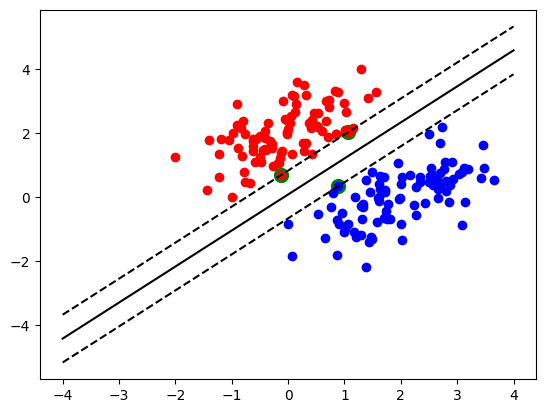

In [78]:
def test_linear():
    X1, y1, X2, y2 = gen_lin_separable_data()
    X_train, y_train = split_train(X1, y1, X2, y2)
    X_test, y_test = split_test(X1, y1, X2, y2)

    clf = SVM()
    clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)
    correct = np.sum(y_predict == y_test)
    print("%d out of %d predictions correct" % (correct, len(y_predict)))

    plot_margin(X_train[y_train==1], X_train[y_train==-1], clf)
    
test_linear()


     pcost       dcost       gap    pres   dres
 0: -5.8476e+01 -1.7744e+02  6e+02  2e+01  2e+00
 1: -9.5088e+01 -2.4499e+02  3e+02  1e+01  1e+00
 2: -1.9356e+02 -3.4954e+02  3e+02  8e+00  8e-01
 3: -2.9750e+02 -4.6167e+02  3e+02  7e+00  7e-01
 4: -6.0534e+02 -7.5368e+02  2e+02  4e+00  4e-01
 5: -6.1362e+02 -7.0071e+02  9e+01  3e-02  3e-03
 6: -6.6902e+02 -6.7317e+02  4e+00  4e-04  4e-05
 7: -6.7244e+02 -6.7251e+02  7e-02  7e-06  7e-07
 8: -6.7250e+02 -6.7250e+02  7e-04  7e-08  7e-09
 9: -6.7250e+02 -6.7250e+02  7e-06  7e-10  7e-11
Optimal solution found.
7 support vectors out of 180 points
20 out of 20 predictions correct


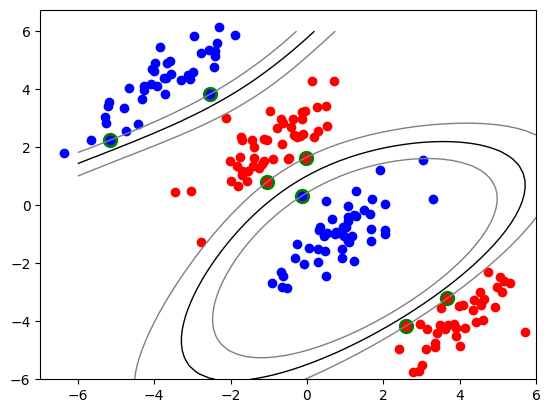

In [79]:
def test_non_linear():
    X1, y1, X2, y2 = gen_non_lin_separable_data()
    X_train, y_train = split_train(X1, y1, X2, y2)
    X_test, y_test = split_test(X1, y1, X2, y2)

    clf = SVM(gaussian_kernel)
    clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)
    correct = np.sum(y_predict == y_test)
    print("%d out of %d predictions correct" % (correct, len(y_predict)))

    plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)
    
test_non_linear()

     pcost       dcost       gap    pres   dres
 0: -2.0627e+01 -3.0497e+01  9e+02  2e+01  7e-15
 1: -3.8481e+00 -2.7807e+01  6e+01  1e+00  6e-15
 2: -2.2735e+00 -1.1030e+01  1e+01  1e-01  1e-15
 3: -2.2921e+00 -3.8001e+00  2e+00  1e-02  1e-15
 4: -2.5635e+00 -3.0099e+00  5e-01  3e-03  1e-15
 5: -2.6323e+00 -2.8558e+00  2e-01  1e-03  1e-15
 6: -2.6846e+00 -2.7344e+00  5e-02  1e-04  1e-15
 7: -2.6988e+00 -2.7136e+00  2e-02  4e-05  9e-16
 8: -2.7039e+00 -2.7063e+00  2e-03  8e-16  1e-15
 9: -2.7050e+00 -2.7051e+00  7e-05  6e-16  1e-15
10: -2.7051e+00 -2.7051e+00  7e-07  4e-16  1e-15
Optimal solution found.
36 support vectors out of 180 points
19 out of 20 predictions correct


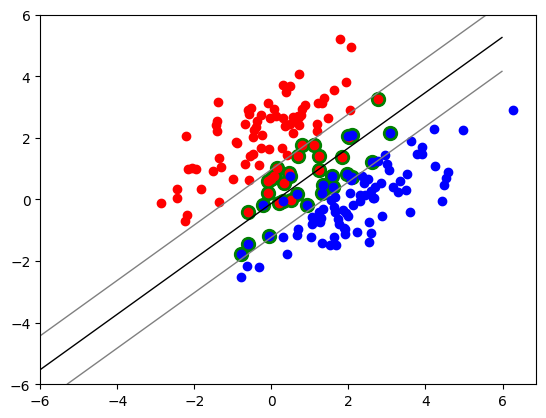

In [80]:
def test_soft():
    X1, y1, X2, y2 = gen_lin_separable_overlap_data()
    X_train, y_train = split_train(X1, y1, X2, y2)
    X_test, y_test = split_test(X1, y1, X2, y2)

    clf = SVM(C=0.1)
    clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)
    correct = np.sum(y_predict == y_test)
    print("%d out of %d predictions correct" % (correct, len(y_predict)))

    plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)

test_soft()

## Cách 2: Sử dụng thư viện sklearn:

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.datasets import make_circles

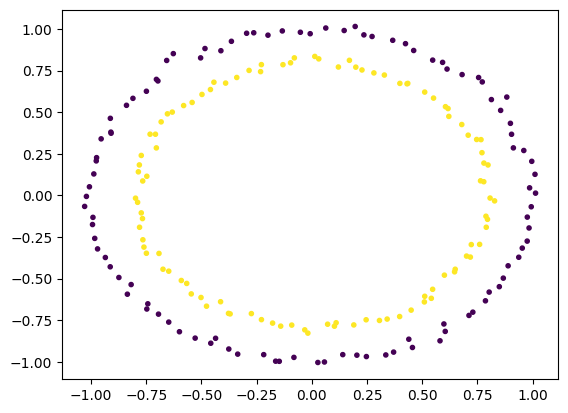

In [82]:
# Generate dataset and targets
X, Y = make_circles(n_samples = 200, noise = 0.02)

# visualizing data
plt.scatter(X[:, 0], X[:, 1], c = Y, marker = '.')
plt.show()

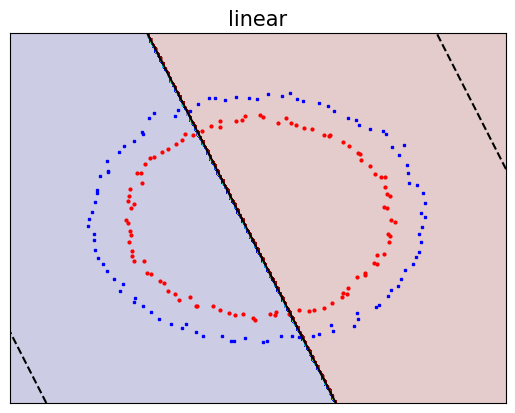

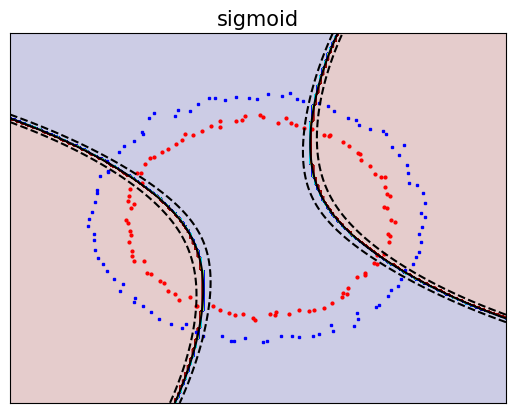

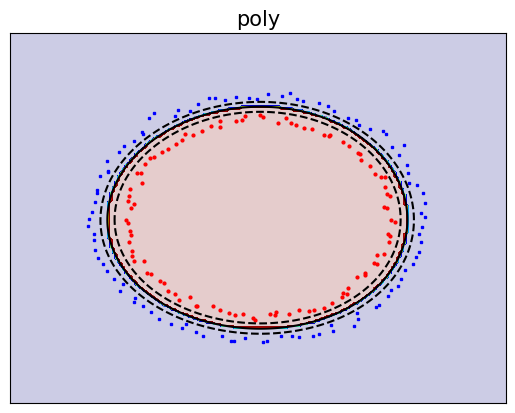

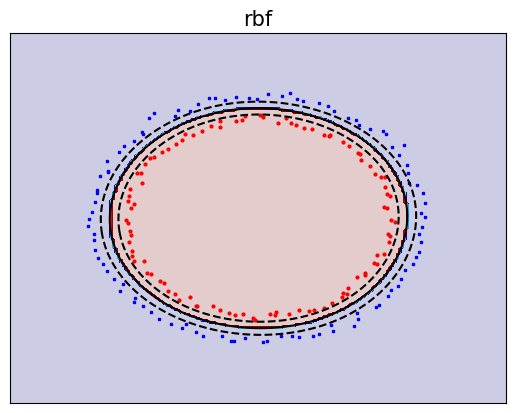

In [83]:
fignum = 1

# fit the model
for kernel in ('linear','sigmoid', 'poly', 'rbf'):
    clf = svm.SVC(kernel=kernel, gamma=1, coef0 = 1)
    clf.fit(X, Y)
    
    with PdfPages(kernel + '3.pdf') as pdf:
        # plot the line, the points, and the nearest vectors to the plane
        fig, ax = plt.subplots()
        plt.figure(fignum, figsize=(5, 5))
        plt.clf()
        
        plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80,
        facecolors='None')
        plt.plot(X[Y==0, 0], X[Y==0, 1], 'bs', markersize = 2)
        plt.plot(X[Y==1, 0], X[Y==1, 1], 'ro', markersize = 2)
        plt.axis('tight')
        x_min = -1.5
        x_max = 1.5
        y_min = -1.5
        y_max = 1.5
        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        plt.figure(fignum, figsize=(5, 5))
        CS = plt.contourf(XX, YY, np.sign(Z), 200, cmap='jet', alpha = .2)
        plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
        levels=[-.5, 0, .5])
        plt.title(kernel, fontsize = 15)
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.xticks(())
        plt.yticks(())
        fignum = fignum + 1
        pdf.savefig()
        
plt.show()

# Bài tập thực hành 1  
Cho tệp dữ liệu đính kèm ARgender.mat, đoạn lệnh sau đây sẽ đọc tệp dữ liệu đó và chia làm hai phần dữ liệu Training và Test Data.

In [84]:
import scipy.io as sio
from sklearn.svm import SVC

A = sio.loadmat("ARgender.mat")

X_train = A['Y_train'].T
X_test = A['Y_test'].T

In [85]:
print(X_train.shape)
print(X_test.shape)

(700, 300)
(700, 300)


In [86]:
N = 700
y_train = A['label_train'].reshape(N)
y_test = A['label_test'].reshape(N)

In [87]:
print(y_train)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 

In [88]:
y_test.shape

(700,)

In [89]:
# Chuyển y_train kiểu float64
y_train = y_train.astype(np.float64)

# Chuyển y_test kiểu float64
y_test = y_test.astype(np.float64)


In [90]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

In [91]:
# Train and evaluate SVM models with different kernels
def train_and_evaluate(kernel):
    svm = SVC(kernel=kernel)
    svm.fit(X_train, y_train)
    y_pred_train = svm.predict(X_train)
    y_pred_test = svm.predict(X_test)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    return train_accuracy, test_accuracy

In [92]:
# Test linear kernel
train_acc_linear, test_acc_linear = train_and_evaluate('linear')
print("Linear Kernel - Train Accuracy: {:.2f}, Test Accuracy: {:.2f}".format(train_acc_linear, test_acc_linear))

Linear Kernel - Train Accuracy: 0.91, Test Accuracy: 0.90


In [93]:
# Test RBF kernel
train_acc_rbf, test_acc_rbf = train_and_evaluate('rbf')
print("RBF Kernel - Train Accuracy: {:.2f}, Test Accuracy: {:.2f}".format(train_acc_rbf, test_acc_rbf))

RBF Kernel - Train Accuracy: 0.95, Test Accuracy: 0.91


In [94]:
# Test polynomial kernel
train_acc_poly, test_acc_poly = train_and_evaluate('poly')
print("Polynomial Kernel - Train Accuracy: {:.2f}, Test Accuracy: {:.2f}".format(train_acc_poly, test_acc_poly))

Polynomial Kernel - Train Accuracy: 0.97, Test Accuracy: 0.91


## Nhận xét:

Cả ba mô hình đều cho thấy hiệu suất tốt trên tập kiểm tra, với độ chính xác trên 90%.
RBF kernel sử dụng hàm Radial Basis Function, cho phép tạo ra các đường biên phân loại phi tuyến. Trong trường hợp này, mô hình có train accuracy cao hơn so với linear kernel, có thể là do khả năng tốt hơn của nó trong việc phân loại các điểm dữ liệu phi tuyến. Mô hình sử dụng kernel đa thức có vẻ có hiệu suất tốt nhất trên tập huấn luyện, nhưng có thể có overfitting nhẹ trên tập kiểm tra.

Polynomial kernel sử dụng một hàm đa thức để tạo ra đường biên phân loại. Kết quả train accuracy cao hơn cả hai loại kernel trước, có thể do khả năng của nó trong việc phân loại các điểm dữ liệu phức tạp hơn. Tuy nhiên, độ chính xác trên tập kiểm tra thấp hơn tập huấn luyện 1 chút -> có thể có thể có overfitting nhẹ

Mô hình sử dụng Kernel linear cho kết quả tốt và ổn định trên cả hai tập dữ liệu. Linear kernel sử dụng một hàm tuyến tính để tạo ra đường biên phân loại. Điều này có nghĩa là nó giả định rằng các lớp là tách biệt tuyến tính. Tuy nhiên, nó có thể không phân loại các điểm dữ liệu phức tạp một cách hiệu quả khi không gian đặc trưng không phải là tuyến tính.




# Bài tập tự thực hành 2

In [95]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

In [96]:
dataset = pd.read_csv('dataset.csv')
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [97]:
X.shape

(400, 2)

In [98]:
X

array([[    19,  19000],
       [    35,  20000],
       [    26,  43000],
       [    27,  57000],
       [    19,  76000],
       [    27,  58000],
       [    27,  84000],
       [    32, 150000],
       [    25,  33000],
       [    35,  65000],
       [    26,  80000],
       [    26,  52000],
       [    20,  86000],
       [    32,  18000],
       [    18,  82000],
       [    29,  80000],
       [    47,  25000],
       [    45,  26000],
       [    46,  28000],
       [    48,  29000],
       [    45,  22000],
       [    47,  49000],
       [    48,  41000],
       [    45,  22000],
       [    46,  23000],
       [    47,  20000],
       [    49,  28000],
       [    47,  30000],
       [    29,  43000],
       [    31,  18000],
       [    31,  74000],
       [    27, 137000],
       [    21,  16000],
       [    28,  44000],
       [    27,  90000],
       [    35,  27000],
       [    33,  28000],
       [    30,  49000],
       [    26,  72000],
       [    27,  31000],


In [99]:
y.shape

(400,)

In [100]:
y

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,

In [101]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [102]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [103]:
X_train

array([[ 0.58164944, -0.88670699],
       [-0.60673761,  1.46173768],
       [-0.01254409, -0.5677824 ],
       [-0.60673761,  1.89663484],
       [ 1.37390747, -1.40858358],
       [ 1.47293972,  0.99784738],
       [ 0.08648817, -0.79972756],
       [-0.01254409, -0.24885782],
       [-0.21060859, -0.5677824 ],
       [-0.21060859, -0.19087153],
       [-0.30964085, -1.29261101],
       [-0.30964085, -0.5677824 ],
       [ 0.38358493,  0.09905991],
       [ 0.8787462 , -0.59677555],
       [ 2.06713324, -1.17663843],
       [ 1.07681071, -0.13288524],
       [ 0.68068169,  1.78066227],
       [-0.70576986,  0.56295021],
       [ 0.77971394,  0.35999821],
       [ 0.8787462 , -0.53878926],
       [-1.20093113, -1.58254245],
       [ 2.1661655 ,  0.93986109],
       [-0.01254409,  1.22979253],
       [ 0.18552042,  1.08482681],
       [ 0.38358493, -0.48080297],
       [-0.30964085, -0.30684411],
       [ 0.97777845, -0.8287207 ],
       [ 0.97777845,  1.8676417 ],
       [-0.01254409,

In [104]:
X_train.shape

(300, 2)

In [105]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

def train_and_evaluate(kernel):
    svm = SVC(kernel=kernel)
    svm.fit(X_train, y_train)
    y_pred_train = svm.predict(X_train)
    y_pred_test = svm.predict(X_test)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    return train_accuracy, test_accuracy

In [106]:
# Test linear kernel
train_acc_linear, test_acc_linear = train_and_evaluate('linear')
print("Linear Kernel - Train Accuracy: {:.2f}, Test Accuracy: {:.2f}".format(train_acc_linear, test_acc_linear))

Linear Kernel - Train Accuracy: 0.82, Test Accuracy: 0.90


In [107]:
# Test RBF kernel
train_acc_rbf, test_acc_rbf = train_and_evaluate('rbf')
print("RBF Kernel - Train Accuracy: {:.2f}, Test Accuracy: {:.2f}".format(train_acc_rbf, test_acc_rbf))

RBF Kernel - Train Accuracy: 0.91, Test Accuracy: 0.93


In [108]:
# Test polynomial kernel
train_acc_poly, test_acc_poly = train_and_evaluate('poly')
print("Polynomial Kernel - Train Accuracy: {:.2f}, Test Accuracy: {:.2f}".format(train_acc_poly, test_acc_poly))

Polynomial Kernel - Train Accuracy: 0.83, Test Accuracy: 0.86


## Nhận xét

Mô hình sử dụng Linear Kernel cho thấy độ chính xác trên tập kiểm tra (90%) cao hơn so với độ chính xác trên tập huấn luyện (82%). Điều này cho thấy mô hình hợp lý hóa và tìm hiểu được các quy luật và mẫu trong tập dữ liệu huấn luyện và áp dụng tốt lên tập dữ liệu kiểm tra. 

Mô hình sử dụng RBF Kernel cho thấy độ chính xác trên cả tập huấn luyện và tập kiểm tra đều khá cao. Điều này cho thấy mô hình có khả năng tìm hiểu và áp dụng tốt các quy luật và mẫu trong dữ liệu. Độ chính xác trên tập kiểm tra (93%) cao hơn so với độ chính xác trên tập huấn luyện (91%), cho thấy mô hình không bị overfitting (quá khớp) và có khả năng tổng quát hóa tốt trên dữ liệu mới.

Mô hình sử dụng Polynomial Kernel cho thấy độ chính xác trên cả tập huấn luyện và tập kiểm tra đều tương đối cao. Tuy nhiên, độ chính xác trên tập kiểm tra (86%) thấp hơn so với độ chính xác trên tập huấn luyện (83%), có thể cho thấy mô hình có hiện tượng overfitting 

# Bài tập thực hành 3

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load breast cancer dataset
data = load_breast_cancer()

X = data.data
y = data.target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [110]:
from sklearn.svm import SVC

# Initialize SVM classifiers with different kernels
linear_svc = SVC(kernel='linear')
rbf_svc = SVC(kernel='rbf')
poly_svc = SVC(kernel='poly')

# Train SVM classifiers
linear_svc.fit(X_train, y_train)
rbf_svc.fit(X_train, y_train)
poly_svc.fit(X_train, y_train)

# Evaluate the models
linear_train_acc = linear_svc.score(X_train, y_train)
linear_test_acc = linear_svc.score(X_test, y_test)

rbf_train_acc = rbf_svc.score(X_train, y_train)
rbf_test_acc = rbf_svc.score(X_test, y_test)

poly_train_acc = poly_svc.score(X_train, y_train)
poly_test_acc = poly_svc.score(X_test, y_test)

print("Linear Kernel - Train Accuracy:", linear_train_acc, "Test Accuracy:", linear_test_acc)
print("RBF Kernel - Train Accuracy:", rbf_train_acc, "Test Accuracy:", rbf_test_acc)
print("Polynomial Kernel - Train Accuracy:", poly_train_acc, "Test Accuracy:", poly_test_acc)

Linear Kernel - Train Accuracy: 0.9868131868131869 Test Accuracy: 0.956140350877193
RBF Kernel - Train Accuracy: 0.989010989010989 Test Accuracy: 0.9824561403508771
Polynomial Kernel - Train Accuracy: 0.9142857142857143 Test Accuracy: 0.868421052631579


## Nhận xét:

Mô hình SVM sử dụng kernel linear cho kết quả chính xác trên tập huấn luyện cao (98.68%) và trên tập kiểm tra cũng khá cao (95.61%).


RBF kernel tạo ra đường biên phân loại phi tuyến, cho phép phân loại dữ liệu không gian đặc trưng phi tuyến. Mô hình với kernel này đạt được độ chính xác cao trên cả tập huấn luyện (98.90%) và tập kiểm tra (98.25%). Sự chênh lệch giữa hai kết quả này nhỏ, cho thấy mô hình có khả năng tổng quát hóa tốt trên dữ liệu mới. 

Kernel đa thức cũng tạo ra đường biên phân loại phi tuyến nhưng bằng cách sử dụng hàm đa thức thay vì hàm Gauss. Mặc dù mô hình có độ chính xác trên tập huấn luyện không quá xa so với hai loại kernel khác, nhưng trên tập kiểm tra, độ chính xác của mô hình giảm đáng kể. Điều này có thể cho thấy rằng kernel đa thức có thể không phù hợp với dữ liệu này hoặc cần được điều chỉnh thêm các siêu tham số để cải thiện hiệu suất.